In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import precision_score, recall_score, auc, accuracy_score, roc_auc_score, f1_score, log_loss,\
classification_report, roc_curve, confusion_matrix


RND_STATE = 777

In [2]:
datasets_path = ["Train_wo_na.csv", "Valid_wo_na.csv", "Control_wo_na.csv"]

train = pd.read_csv(fr'Data\{datasets_path[0]}', encoding='cp1251', index_col = 0).copy()
valid = pd.read_csv(fr'Data\{datasets_path[1]}', encoding='cp1251', index_col = 0).copy()
test = pd.read_csv(fr'Data\{datasets_path[2]}', encoding='cp1251', index_col = 0).copy()

In [14]:
cat_cols = train.dtypes[train.dtypes == 'object'].index

train_label = pd.get_dummies(train, columns=cat_cols, drop_first=True)
valid_label = pd.get_dummies(valid, columns=cat_cols, drop_first=True)
test_label = pd.get_dummies(test, columns=cat_cols, drop_first=True)

In [15]:
X_train = train_label.drop('open_account_flg', axis=1)
y_train = train_label['open_account_flg']

X_valid = valid_label.drop('open_account_flg', axis=1)
y_valid = valid_label['open_account_flg']

X_test = test_label.drop('open_account_flg', axis=1)
y_test = test_label['open_account_flg']

Сейчас мы посмотрим как работают деревья решений и так называемые ансамблевые методы, когда применяется несколько деревьев и проводится голосование. Два основных типа ансамблей - бэггинг и бустинг. 

Бэггинг предполагает создание нескольких деревьев. Каждое дерево тренируется на наборе данных, который извлечен из наших базовых наборов путем отбора наблюдений и признаков.

Бустинг предполагает также создание нескольких деревьев. Но деревья тренируются не параллельно, а последовательно. Причем на каждом последующем шаге учитываются результаты предыдущего. 

Рекомендую ознакомиться с этими методами по книге Практическая статистика для специалистов Data Science (Питер Брюс, Эндрю Брюс). Хороший материал по деревьям [здесь](https://loginom.ru/blog/decision-tree-p1)

In [16]:
lr_metrics = pd.DataFrame(index=['roc-auc', 'precision',
                                 'recall', 'f1', 'logloss'])

In [21]:
def make_tree_classifier(x_train, y_train, x_valid, y_valid, results_df, model_name,
                         model_type, parameters={'min_samples_leaf':20}):
    model_types={
        'tree':DecisionTreeClassifier,
        'RF':RandomForestClassifier
    }
    
    model = model_types[model_type](**parameters,
                                     class_weight = 'balanced',
                                     random_state=RND_STATE)
    model.fit(x_train, y_train)
    
    y_pred = model.predict(x_valid)
    y_score = model.predict_proba(x_valid)[:,1]
    
    results_df[model_name] = [roc_auc_score(y_valid, y_score),
                              precision_score(y_valid, y_pred),
                              recall_score(y_valid, y_pred),
                              f1_score(y_valid, y_pred),
                              log_loss(y_valid, y_pred)]
    
    fpr_baseline, tpr_baseline, thresholds = roc_curve(y_valid, y_score)

    roc_auc_baseline = auc(fpr_baseline, tpr_baseline)

    plt.plot(fpr_baseline, tpr_baseline, color='orange',
             label=f'ROC curve (area = {roc_auc_baseline:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    plt.title('Tree-based classifier ROC AUC')
    plt.legend(loc="lower right")
    plt.show()
    return model

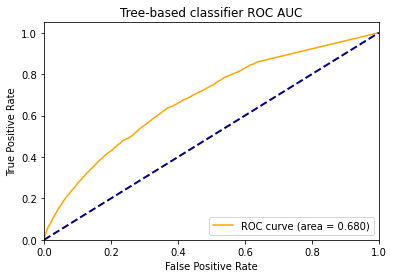

In [20]:
basic_tree = make_tree_classifier(x_train=X_train,
                                  y_train=y_train,
                                  x_valid=X_valid,
                                  y_valid=y_valid,
                                  results_df=lr_metrics,
                                  model_name='basic_tree',
                                  model_type='tree')

In [22]:
lr_metrics

,basic_tree
roc-auc,0.679725
precision,0.274826
recall,0.602880
f1,0.377546
logloss,12.085777


In [ ]:
decision_tree = DecisionTreeClassifier

In [7]:
DecisionTreeClassifier?

Object `DecisionTreeClassifier` not found.
